In [58]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

import kad.visualization.visualization as visualization
from kad.kad_utils import kad_utils
from kad.kad_utils.kad_utils import customize_matplotlib
import kad.model.autoencoder_model as autoencoder_model
import kad.model.lstm_model as lstm_model
from kad.model.sarima_model import SarimaModel
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from sklearn.model_selection import train_test_split

customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython', '/snap/pycharm-professional/240/plugins/python/helpers/pydev', '/snap/pycharm-professional/240/plugins/python/helpers-pro/jupyter_debug']


In [2]:
data_dir = "data/archive/"
file_dir = "realAWSCloudwatch"
file_name = "realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df[:int(len(original_df)/2)].resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

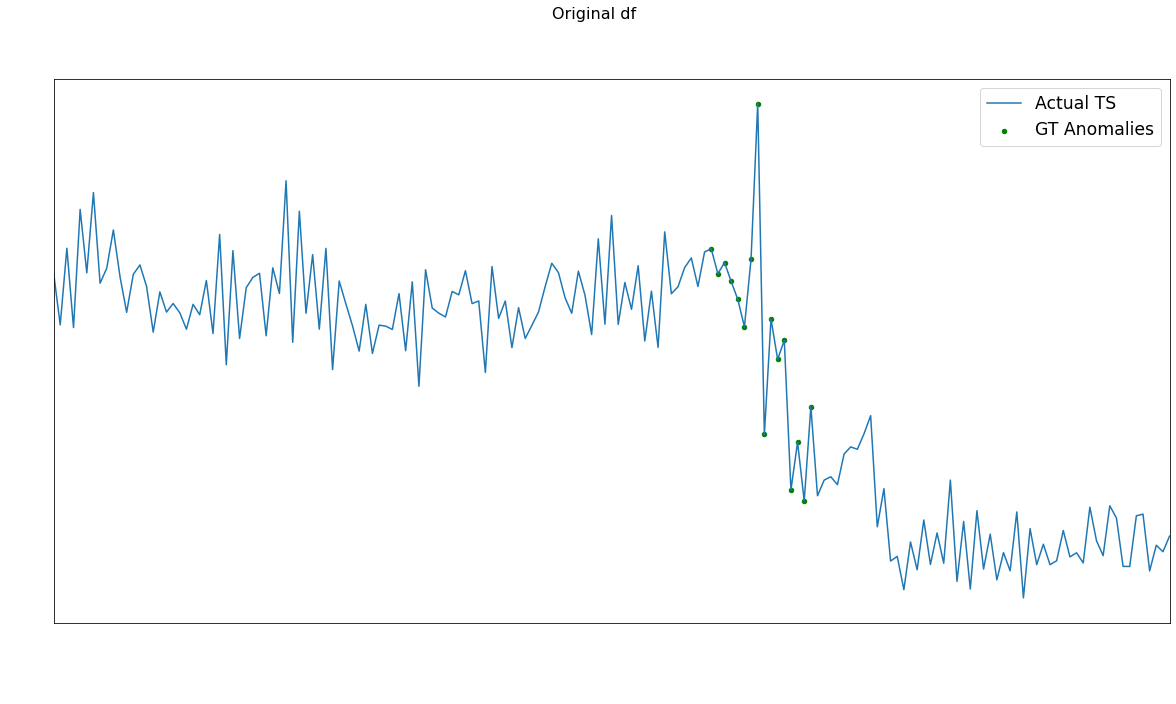

In [3]:
X_LABEL = "timestamp"
ts_analyzer = importlib.reload(ts_analyzer)

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index  for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")


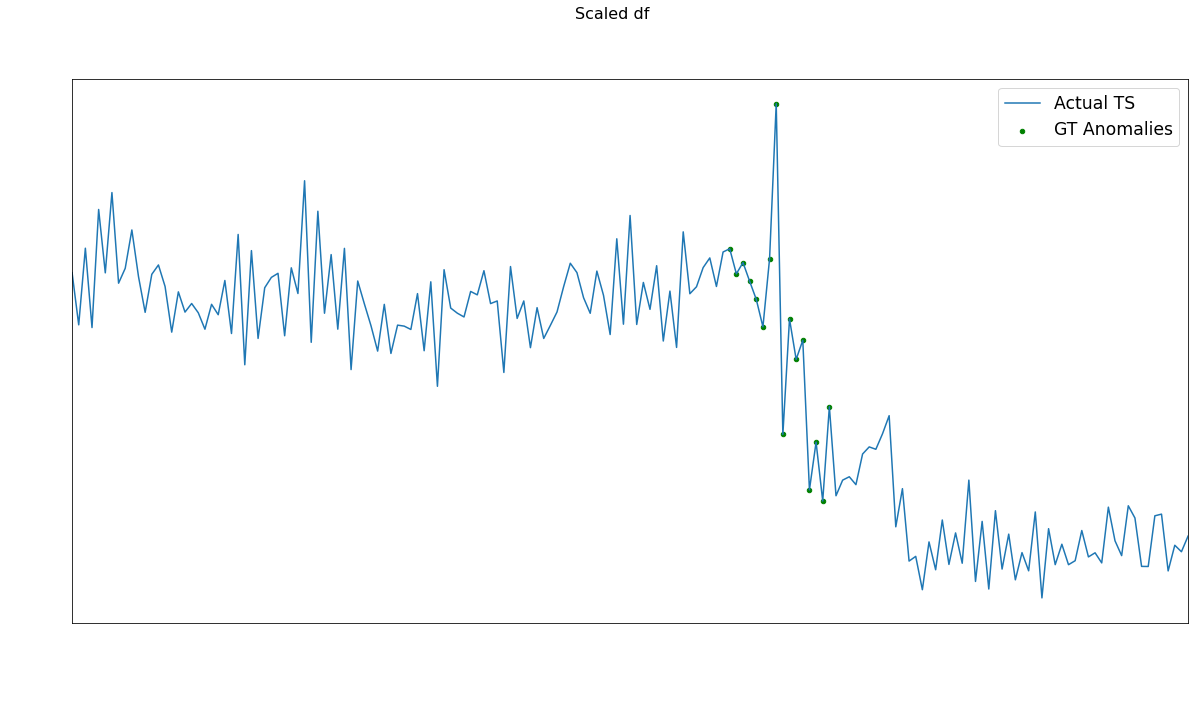

In [62]:
scaler = MinMaxScaler(feature_range=(-1, 0))
# scaler = StandardScaler()
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 12, 64)            16896     
_________________________________________________________________
lstm_45 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 3s 70ms/step - loss: 0.1752 - val_loss: 0.1131
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.1186 - val_loss: 0.0717

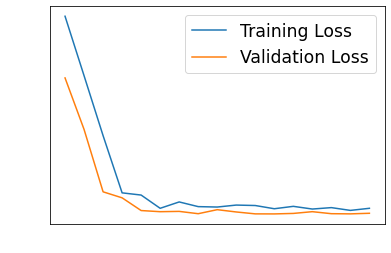

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/model/lstm_model.py:67: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  self.result_df.loc[-len(forecast):, "predictions"] = forecast
/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/kad/model/lstm_model.py:94: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  temp_df.loc[-len(forecast):, "predictions"] = forecast


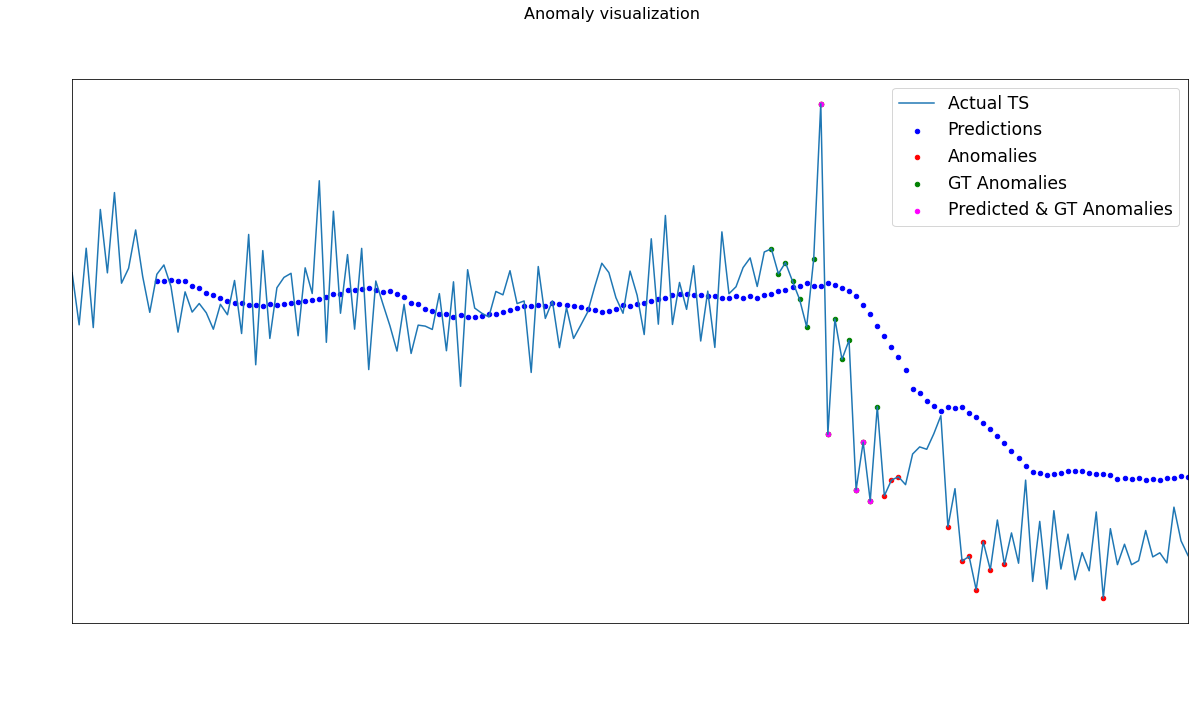

In [63]:
lstm_model = importlib.reload(lstm_model)
model: i_model.IModel = lstm_model.LstmModel(time_steps=12)

values_df = preprocessed_df[["value"]]
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.5)
model.train(train_df)

results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 25
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    if len(test_df.iloc[i:i+SAMPLES_TO_PREDICT]) < SAMPLES_TO_PREDICT:
        break
    results_df = model.test(test_df.iloc[i:i+SAMPLES_TO_PREDICT])

evaluation_df = results_df.copy()
evaluation_df["gt_is_anomaly"] = preprocessed_df["gt_is_anomaly"]
visualization = importlib.reload(visualization)
visualization.visualize(evaluation_df, "value")



In [42]:
results_df[test_df.columns[0]].to_numpy()[-12:]

array([-0.85991551, -0.93273185, -0.8914223 , -0.93281809, -0.92476891,
       -0.86365263, -0.91706469, -0.90875679, -0.92919596, -0.81639244,
       -0.88443677, -0.91447746])